# PCam Small CNN: Step-by-step walkthrough
- Goal: establish a baseline, test short hypotheses, then prepare hyperparameter tuning and a final run.
- We start small (CPU, limited split), observe what works, and scale up gradually.

## 1) Setup & Assumptions
- CPU run for debugging; limited dataset for fast iteration.
- Metric focus: val AUROC (primary), AUPRC (secondary). Loss used for stability checks.
- Initial hypothesis: a small CNN will generalize with a moderate LR and light weight decay; batch size affects stability on CPU.
- Reproducibility: the notebook sets a random seed (seed=42) to make runs repeatable on CPU.

In [ ]:
import torch
from pathlib import Path
from typing import Dict
import optuna
import os
import numpy as np, random

from src.datasets.dataloaders import get_pcam_dataloaders
from src.models.small_cnn_gpu import SmallCNN
from src.training.train_small_cnn_gpu import evaluate

# Device setting: prefer GPU when available; fall back to CPU otherwise
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
DATA_ROOT = Path("data/raw")
CENTER_CROP = 64

# Base settings for quick runs (adjusted further below)
LIMIT_DEBUG = 2000     # None for full split; keep small for CPU iterations

NUM_WORKERS = max(1, (os.cpu_count() or 4) - 1)  # use multiple workers; reduce on CPU-only machines if necessary
EPOCHS_DEBUG = 2
BATCH_DEBUG = 32
LR_DEBUG = 1e-3
WD_DEBUG = 1e-4

# Reproducibility
seed=42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)


Using device: cpu


Why these defaults?
- `LIMIT_DEBUG=512`: minimizes I/O and compute time, enough for coarse trends.
- `LR_DEBUG=1e-3`: a robust starting point for Adam with small CNNs; often works without divergence.
- `WD_DEBUG=1e-4`: light regularization to prevent overfitting on small splits.
- `BATCH_DEBUG=32`: balance between stability and CPU speed.

In [ ]:
def make_loaders(batch_size: int, limit: int | None) -> Dict[str, torch.utils.data.DataLoader]:
    return get_pcam_dataloaders(
        data_root=DATA_ROOT,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        center_crop_size=CENTER_CROP,
        limit_per_split=limit,
    )


def train_one_run(
    batch_size: int,
    lr: float,
    weight_decay: float,
    epochs: int,
    limit: int | None,
    dropout_p: float = 0.1,
    patience: int = 2,
    use_scheduler: bool = True,
    verbose: bool = True,
):
    loaders = make_loaders(batch_size, limit)
    model = SmallCNN(dropout_p=dropout_p).to(DEVICE)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = (
        torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=1, verbose=verbose
        )
        if use_scheduler
        else None
    )

    best_val_loss = float("inf")
    best_state = None
    bad_epochs = 0
    history = []
    # also track best model by AUROC (keeps a separate state_dict)
    best_val_auroc = float("-inf")
    best_state_auroc = None
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for images, labels in loaders["train"]:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(loaders["train"].dataset)
        val_loss, val_auroc, val_auprc = evaluate(model, loaders["val"], criterion, DEVICE)

        if scheduler:
            scheduler.step(val_loss)

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_auroc": val_auroc,
                "val_auprc": val_auprc,
                "lr": optimizer.param_groups[0]["lr"],
            }
        )

        improved = val_loss < best_val_loss
        if improved:
            best_val_loss = val_loss
            best_state = model.state_dict()
            bad_epochs = 0
        else:
            bad_epochs += 1

        # update best-by-AUROC state if current val AUROC improved
        if val_auroc is not None and val_auroc > best_val_auroc:
            best_val_auroc = val_auroc
            best_state_auroc = model.state_dict()

        if verbose:
            print(
                f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
                f"val_loss={val_loss:.4f} | AUROC={val_auroc:.3f} | AUPRC={val_auprc:.3f} | lr={optimizer.param_groups[0]['lr']:.2e}"
            )

        if bad_epochs > patience:
            if verbose:
                print(f"Early stopping at epoch {epoch} (no val improvement for {bad_epochs} epochs)")
            break

    return history, best_state, best_state_auroc


## 2) Baseline on a small split
Hypothesis: with moderate LR/WD we expect reasonable AUROC > 0.8 after a few epochs on 512 samples. If unstable, adjust LR or batch size.

In [10]:
DO_BASELINE = True
if DO_BASELINE:
    hist_baseline, _, _ = train_one_run(
        batch_size=BATCH_DEBUG,
        lr=LR_DEBUG,
        weight_decay=WD_DEBUG,
        epochs=EPOCHS_DEBUG,
        limit=LIMIT_DEBUG,
    )
    hist_baseline

/opt/anaconda3/envs/torch312/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 | train_loss=0.5165 | val_loss=0.4944 | AUROC=0.859 | AUPRC=0.860 | lr=1.00e-03
Epoch 02 | train_loss=0.4780 | val_loss=0.5509 | AUROC=0.851 | AUPRC=0.863 | lr=1.00e-03
Epoch 02 | train_loss=0.4780 | val_loss=0.5509 | AUROC=0.851 | AUPRC=0.863 | lr=1.00e-03


Interpreting the baseline (manually after the run):
- If AUROC quickly exceeds 0.8, the model learns stably → we can fine-tune.
- If loss fluctuates or AUROC stays below 0.7 → reduce LR (e.g. 5e-4) or increase batch size (if using GPU); on CPU, smaller batches often give more stability.

## 3) Targeted tuning (Optuna, small search space)
Idea: small search on CPU with pruning to probe LR / weight decay / batch size.
- Search space: `lr` 1e-4..8e-4 (log), `weight_decay` 1e-5..1e-3 (log), `batch_size` {16, 32} for CPU.
- Keep trials small (5–10) and use `LIMIT_DEBUG`.
- Disabled by default; enable Optuna when you want to run the search.

### Recommended Optuna settings (full dataset/GPU)
- Trials: start with 10–20; increase to ~30 if time, keep pruning on.
- Epochs per trial: 2–3 on full data to keep runtime reasonable.
- Search space suggestions:
  - lr: 1e-4 to 1e-3 (log), optionally up to 2e-3 if scheduler.
  - weight_decay: 1e-6 to 1e-3 (log).
  - batch_size: 32/64/96 (CPU: 16/32).
  - dropout_p: 0.05–0.2 (optional to tune).
- Strategy: run small trials, then train top 2–3 configs longer with scheduler/early stopping.


In [11]:
DO_OPTUNA = True

def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 8e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    dropout_p = trial.suggest_float("dropout_p", 0.05, 0.2)

    loaders = make_loaders(batch_size, LIMIT_DEBUG)
    model = SmallCNN(dropout_p=dropout_p).to(DEVICE)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, EPOCHS_DEBUG + 1):
        model.train()
        for images, labels in loaders["train"]:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        _, val_auroc, _ = evaluate(model, loaders["val"], criterion, DEVICE)
        trial.report(val_auroc, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_auroc

if DO_OPTUNA:
    study = optuna.create_study(
        direction="maximize",
        study_name="small_cnn_story_cpu",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=1),
    )
    study.optimize(objective, n_trials=12)
    print("Best AUROC:", study.best_value)
    print("Best params:", study.best_params)
    trials_df = study.trials_dataframe()
    trials_df[["number", "value", "state", "params_lr", "params_weight_decay", "params_batch_size", "params_dropout_p"]]

[I 2025-12-13 17:49:48,944] A new study created in memory with name: small_cnn_story_cpu
[I 2025-12-13 17:50:26,318] Trial 0 finished with value: 0.8631074998667901 and parameters: {'lr': 0.00018245162631953205, 'weight_decay': 2.240042228028822e-05, 'batch_size': 16, 'dropout_p': 0.11497879604811465}. Best is trial 0 with value: 0.8631074998667901.
[I 2025-12-13 17:50:26,318] Trial 0 finished with value: 0.8631074998667901 and parameters: {'lr': 0.00018245162631953205, 'weight_decay': 2.240042228028822e-05, 'batch_size': 16, 'dropout_p': 0.11497879604811465}. Best is trial 0 with value: 0.8631074998667901.
[I 2025-12-13 17:51:02,725] Trial 1 finished with value: 0.8550978162628647 and parameters: {'lr': 0.000375408286869242, 'weight_decay': 0.00014192133675716568, 'batch_size': 16, 'dropout_p': 0.06314402688453141}. Best is trial 0 with value: 0.8631074998667901.
[I 2025-12-13 17:51:02,725] Trial 1 finished with value: 0.8550978162628647 and parameters: {'lr': 0.000375408286869242, 'w

Best AUROC: 0.8631074998667901
Best params: {'lr': 0.00018245162631953205, 'weight_decay': 2.240042228028822e-05, 'batch_size': 16, 'dropout_p': 0.11497879604811465}


Interpreting the search results:
- Choose the best parameters as a starting point for the larger run.
- If the search shows little variation, widen the LR range or include `batch_size` 16/32/48 (if using GPU).

**New anti-overfitting measures**:
- Dropout 0.1 before the classifier in SmallCNN.
- ReduceLROnPlateau on val loss (factor 0.5, patience=1) for LR adaptation.
- Early stopping with patience=2 (stop if val does not improve).


## 4) More complete run (more data, more epochs)
Plan: test the best settings on more data and for more epochs.
- On CPU: keep `LIMIT_FINAL` moderate (e.g. 2k–4k) and 6–10 epochs.
- On GPU: `LIMIT_FINAL=None` (full split) and 10–15 epochs, optional LR scheduler (`ReduceLROnPlateau`).

In [ ]:
# Example settings from a good trial
LR_FINAL = 1.8245e-4
WD_FINAL = 2.24e-5
BATCH_FINAL = 16
EPOCHS_FINAL = 10
DROP_FINAL = 0.115
LIMIT_FINAL = None   # None for full dataset; reduce if CPU-bound

DO_FINAL = False

if DO_FINAL:
    hist_final, _, _ = train_one_run(
        batch_size=BATCH_FINAL,
        lr=LR_FINAL,
        weight_decay=WD_FINAL,
        epochs=EPOCHS_FINAL,
        limit=LIMIT_FINAL,
    )
    hist_final

In [ ]:
# Final step: run final training, log results, save model
DO_FINAL = True

# GPU-friendly defaults
BATCH_FINAL = 64
EPOCHS_FINAL = 12
LR_FINAL = 1.8245e-4
WD_FINAL = 2.24e-5
DROP_FINAL = 0.115
LIMIT_FINAL = None  # None for full dataset

if DO_FINAL:
    # Use the programmatic train() helper (supports AMP, checkpoints, and history saving)
    from src.training.train_small_cnn import train

    hist_final, best_state_val, best_state_auroc = train(
        data_root=str(DATA_ROOT),
        num_epochs=EPOCHS_FINAL,
        batch_size=BATCH_FINAL,
        lr=LR_FINAL,
        device=str(DEVICE),
        limit_per_split=LIMIT_FINAL,
        dropout_p=DROP_FINAL,
        num_workers=NUM_WORKERS,
        use_amp=True,
        ckpt_dir=Path("experiments/runs"),
        save_every=1,
    )

    # Summary
    best = max(hist_final, key=lambda x: x["val_auroc"])
    print(
        f"Best epoch (val AUROC): {best['epoch']} | "
        f"train_loss={best['train_loss']:.4f} | val_loss={best['val_loss']:.4f} | AUROC={best['val_auroc']:.3f}"
    )

    from pathlib import Path
    ckpt_dir = Path("experiments/runs")
    print("Saved artifacts:")
    for p in sorted(ckpt_dir.glob("small_cnn_*")):
        print(" -", p)


/opt/anaconda3/envs/torch312/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 | train_loss=0.4438 | val_loss=0.4286 | AUROC=0.896 | AUPRC=0.895 | lr=1.82e-04
Epoch 02 | train_loss=0.3963 | val_loss=0.4100 | AUROC=0.907 | AUPRC=0.904 | lr=1.82e-04
Epoch 03 | train_loss=0.3725 | val_loss=0.3702 | AUROC=0.919 | AUPRC=0.919 | lr=1.82e-04
Epoch 04 | train_loss=0.3555 | val_loss=0.4072 | AUROC=0.914 | AUPRC=0.917 | lr=1.82e-04
Epoch 05 | train_loss=0.3423 | val_loss=0.3520 | AUROC=0.927 | AUPRC=0.926 | lr=1.82e-04
Epoch 06 | train_loss=0.3314 | val_loss=0.3743 | AUROC=0.924 | AUPRC=0.925 | lr=1.82e-04
Epoch 07 | train_loss=0.3226 | val_loss=0.3427 | AUROC=0.930 | AUPRC=0.933 | lr=1.82e-04
Epoch 08 | train_loss=0.3150 | val_loss=0.3431 | AUROC=0.929 | AUPRC=0.933 | lr=1.82e-04
Epoch 09 | train_loss=0.3082 | val_loss=0.3628 | AUROC=0.918 | AUPRC=0.927 | lr=9.12e-05
Epoch 10 | train_loss=0.2924 | val_loss=0.4039 | AUROC=0.921 | AUPRC=0.928 | lr=9.12e-05
Early stopping at epoch 10 (no val improvement for 3 epochs)
Best epoch: 7 | train_loss=0.3226 | val_loss=0.34

## Evaluation on the test split
This section loads the best saved model and evaluates it on the test split. The notebook provides two complementary evaluation flows:
1. Quick test metrics: loads the saved state, runs the `evaluate` helper, and prints loss / AUROC / AUPRC.
2. Detailed analysis: collects logits/probabilities for the whole test set, plots ROC and PR curves, and computes operating thresholds (Youden for ROC and max F1 for PR).

Notes and tips:
- Make sure `experiments/runs/small_cnn_final.pt` exists (created by the training cell above).
- The evaluation code uses `torch.sigmoid` on logits because the model uses a single-output BCEWithLogits head.
- Use the plotted ROC/PR curves and the confusion-matrix snippets to pick an operating threshold that matches your priorities (recall vs precision).
- If you want to re-evaluate with a different dropout or architecture variant, recreate the model with matching arguments before loading the state dict.


In [15]:
# Evaluate on test split using the final/best model
from pathlib import Path
import torch

# Load loaders (full dataset by default)
test_loaders = make_loaders(batch_size=BATCH_FINAL, limit=None)  # adjust limit if needed

# Recreate model with matching dropout and load saved states
model = SmallCNN(dropout_p=DROP_FINAL).to(DEVICE)
state_path = Path("experiments/runs/small_cnn_final.pt")
if state_path.exists():
    model.load_state_dict(torch.load(state_path, map_location=DEVICE))
    print("Loaded saved-by-val-loss model from", state_path)
else:
    print("Saved model not found at", state_path)

# Also try to load best-by-AUROC model for comparison
state_path_auroc = Path("experiments/runs/small_cnn_best_by_auroc.pt")
has_best_auroc = state_path_auroc.exists()
if has_best_auroc:
    print("Found best-by-AUROC model at", state_path_auroc)

criterion = torch.nn.BCEWithLogitsLoss()
# Evaluate saved-by-val-loss model (if loaded)
if state_path.exists():
    test_loss, test_auroc, test_auprc = evaluate(model, test_loaders["test"], criterion, DEVICE)
    print(f"Saved-by-val-loss model -> Test metrics | loss={test_loss:.4f} | AUROC={test_auroc:.3f} | AUPRC={test_auprc:.3f}")
else:
    test_loss = test_auroc = test_auprc = None

# If a best-by-AUROC state exists, evaluate it too for direct comparison
if has_best_auroc:
    model2 = SmallCNN(dropout_p=DROP_FINAL).to(DEVICE)
    model2.load_state_dict(torch.load(state_path_auroc, map_location=DEVICE))
    test_loss_auroc, test_auroc_auroc, test_auprc_auroc = evaluate(model2, test_loaders["test"], criterion, DEVICE)
    print(f"Best-by-AUROC model -> Test metrics | loss={test_loss_auroc:.4f} | AUROC={test_auroc_auroc:.3f} | AUPRC={test_auprc_auroc:.3f}")
else:
    test_loss_auroc = test_auroc_auroc = test_auprc_auroc = None

Test metrics | loss=0.4408 | AUROC=0.913 | AUPRC=0.921


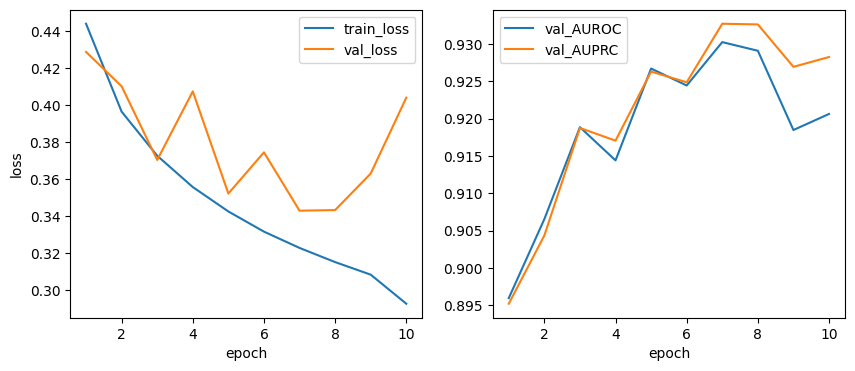

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(hist_final)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(df["epoch"], df["train_loss"], label="train_loss")
ax[0].plot(df["epoch"], df["val_loss"], label="val_loss")
ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].legend()

ax[1].plot(df["epoch"], df["val_auroc"], label="val_AUROC")
ax[1].plot(df["epoch"], df["val_auprc"], label="val_AUPRC")
ax[1].set_xlabel("epoch"); ax[1].legend()
plt.show()

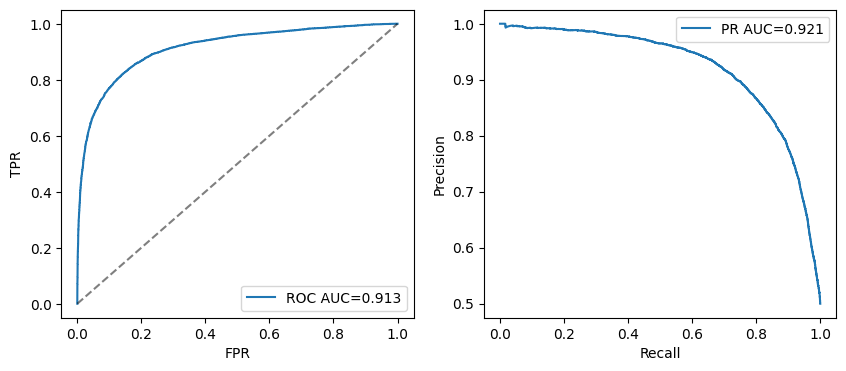

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import torch

# collect logits/probs
model.eval()
all_labels, all_probs = [], []
with torch.no_grad():
    for images, labels in test_loaders["test"]:
        images = images.to(DEVICE)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.numpy())
y_true = np.concatenate(all_labels).ravel()
y_prob = np.concatenate(all_probs).ravel()

fpr, tpr, _ = roc_curve(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
pr_auc = auc(rec, prec)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
ax[0].plot([0,1],[0,1],'k--',alpha=0.5)
ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].legend()

ax[1].plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].legend()
# Save ROC/PR figure and metrics
save_dir = Path("experiments/runs")
save_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(save_dir / "roc_pr_curves.png", dpi=150)

import json
metrics = {"roc_auc": float(roc_auc), "pr_auc": float(pr_auc), "test_loss": (None if test_loss is None else float(test_loss))}
with open(save_dir / "test_metrics_summary.json", "w") as f:
    json.dump(metrics, f, indent=2)

plt.show()


ROC AUC=0.913, PR AUC=0.921
Best Youden threshold=0.237
Best F1 threshold=0.198, F1=0.841

Youden thr=0.237 | F1=0.837
TP=13486, FP=2368, FN=2891, TN=14023


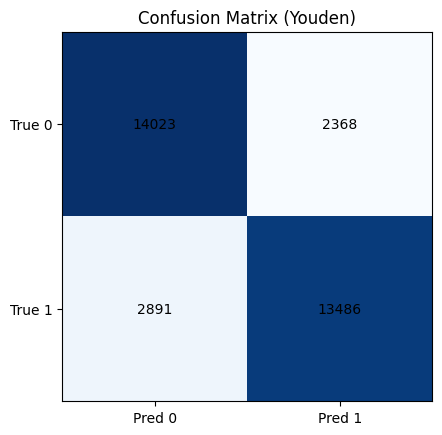


F1 thr=0.198 | F1=0.841
TP=14018, FP=2959, FN=2359, TN=13432


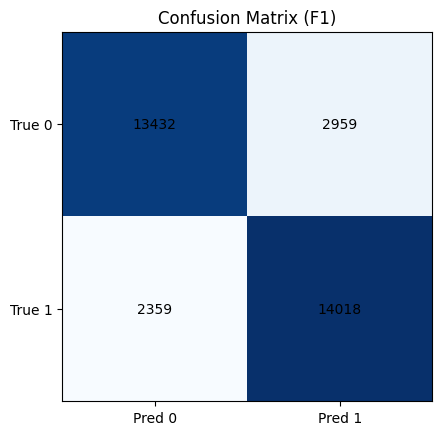

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    f1_score,
    confusion_matrix,
    auc,
)

# Collect test scores/labels (run once)
model.eval()
probs_list, labels_list = [], []
with torch.no_grad():
    for images, labels in test_loaders["test"]:
        images = images.to(DEVICE)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_list.append(probs)
        labels_list.append(labels.numpy())
y_prob = np.concatenate(probs_list).ravel()
y_true = np.concatenate(labels_list).ravel()

# Best thresholds: Youden (ROC) and max F1 (PR)
fpr, tpr, roc_th = roc_curve(y_true, y_prob)
youden_idx = np.argmax(tpr - fpr)
thr_youden = roc_th[youden_idx]

prec, rec, pr_th = precision_recall_curve(y_true, y_prob)
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-8)
f1_idx = np.argmax(f1s)
thr_f1 = pr_th[f1_idx]

roc_auc = auc(fpr, tpr)
pr_auc = auc(rec, prec)

print(f"ROC AUC={roc_auc:.3f}, PR AUC={pr_auc:.3f}")
print(f"Best Youden threshold={thr_youden:.3f}")
print(f"Best F1 threshold={thr_f1:.3f}, F1={f1s[f1_idx]:.3f}")

# Confusion matrix at both thresholds
def cm_at(thr):
    preds = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, preds)
    f1 = f1_score(y_true, preds)
    return cm, f1

for name, thr in [("Youden", thr_youden), ("F1", thr_f1)]:
    cm, f1v = cm_at(thr)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name} thr={thr:.3f} | F1={f1v:.3f}")
    print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0","Pred 1"])
    ax.set_yticklabels(["True 0","True 1"])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", color="black")
    ax.set_title(f"Confusion Matrix ({name})")
    plt.show()
